<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Time series first notebook</h1>
#### Thanks again to Leo Siqueira for contributions

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#stationary">First thing: establishing stationarity</a>
1. <a href="#composing">Composing a sum of Fourier harmonics</a>
1. <a href="#decomposing">Decomposing, using orthogonality</a>
1. <a href="#spectrum">Variance density by frequency (power spectrum)</a>
1. <a href="#autocorrelation">Lagged (auto) correlation/covariance</a>
1. <a href="#AR1noise">AR1 model of geophysical processes</a>

--------

<a name="stationary"></a>
### Stationary Processes

A "process" (time series) X(t) is said to be **Weakly Stationary** if the mean $\mu_X(t)$ and the *lag covariance* $C_{XX}(t,t+\tau) = \overline{X_t \cdot X_{t+\tau}}$ are independent of time $t$. 
A process is said to be **Strongly Stationary** if _all possible probability distributions_ are independent of $t$.  Since this is hard to prove as a practical matter in data, it is just a math distinction, mainly of academic value.

A special category of *weakly stationary* is **ergodic** processes with the property that "given sufficient time, they include or impinge on all points in a given space, and can be represented statistically by a reasonably large selection of points." As scientists, this is what we usually assume. Formally a process is **ergodic** if

\begin{align}
    \mu_X(k) &= \lim_{T\to\infty} \frac{1}{T}\int_0^T X(t)\ \mathrm{d}t\\
    C_{XX}(\tau,k) &= \lim_{T\to\infty}  \frac{1}{T}\int_0^T \left( X_k(t)-\mu_X(t) \right)\left( X_k(t+\tau)-\mu_X(t+\tau) \right)\ \mathrm{d}t\\
\end{align}

-----------

<a name="composing"></a>
### Composing time series from sines and cosines

Let's build up some time series from sines and cosines. Will these be stationary? **Why?** 

In [200]:
%matplotlib inline

import matplotlib.pyplot as plt
# GridSpec lets us align plots carefully 
from matplotlib import gridspec

import scipy.stats as stats
import numpy as np
from numpy.random import rand
from pylab import rcParams, pcolor, show, colorbar, xticks, yticks, title, figure

rcParams['figure.figsize'] = (14, 7)

Let's build a time series **V (with units m/s, for definiteness)** from N different cosines, of different frequency omega, with amplitude A and phase phi. 

\begin{equation}
    X(t) = \Sigma_{i=1}^N A_i \cos (\omega_i t+\phi_i)
\end{equation}

In [201]:
# There's a lowest frequency (1 cycle per record length) omega0
# freq*time ("omega0t") from -pi to pi covers the time domain

omega0t = np.arange(-np.pi, np.pi, 0.01) # will give an odd number of values
NT = len(omega0t)

In [202]:
N = 30                      # How many cosines? 
A   = np.zeros(N) + 1      # Amplitudes: all equal 
A   = 1.0/(1+np.arange(N))  # Triangular spectrum: less of high frequencies 
phi = np.zeros(N)          # phase=0

# phase=random in [0,2pi]
phi = np.random.uniform(low=0, high=2*np.pi, size=N) 

# Create the container, and fill it
V = np.zeros_like(omega0t)
for j in range(N): 
    V += A[j]* np.cos( j*omega0t + phi[j] )
    
# V /= N # Normalize the data by number of components

In [203]:
def fig1():
    fig=plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax=fig.add_subplot(gs[0])
    ax.plot(omega0t,V)
    ax.set_xlabel('omega0t [radians]');ax.set_ylabel('V [m/s]');
    ax=fig.add_subplot(gs[1]); ax.set_xlabel('PDF & normal approx.')
    n,bins,pa=ax.hist(V,101,orientation='horizontal', \
                      normed='True',label='pdf of V')
    # Approximate it with a normal distribution of same mean and std
    normapprox = stats.norm.pdf(bins,loc=np.mean(V),scale=np.std(V)) 
    ax.plot(normapprox, bins)

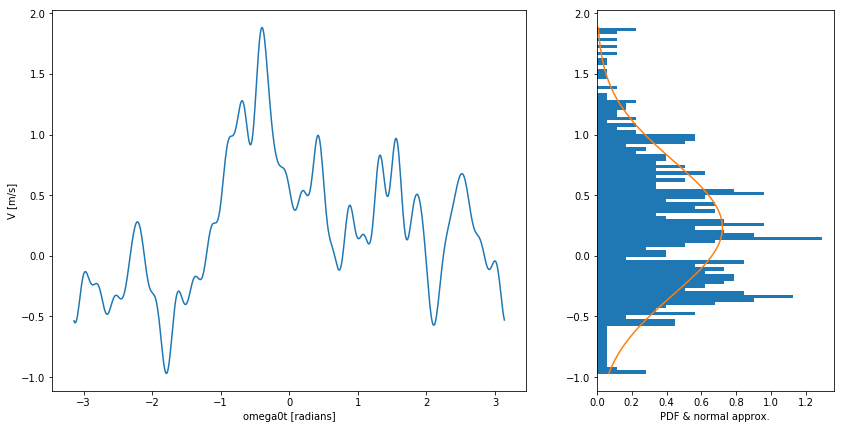

In [204]:
fig1()

<a name="decomposing"></a>
### Decomposing time series: find the sines and cosines

Project a series onto pure cosine -- it gives the coefficient!  

Text(0.5,1,'This component has amplitude 0.010473696443445438 m/s')

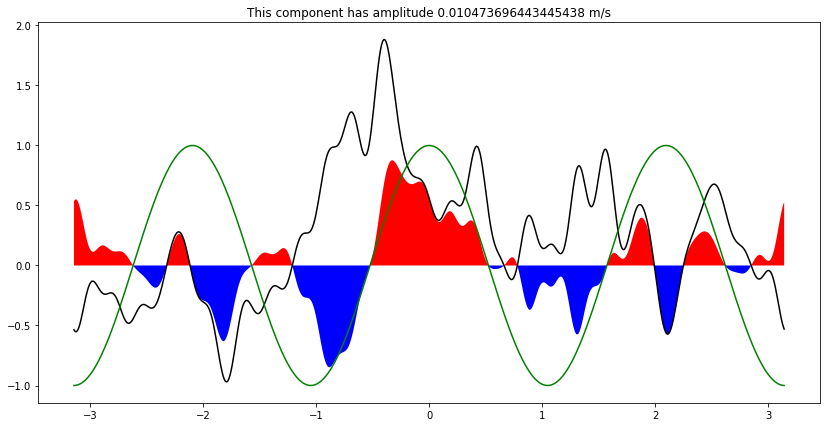

In [205]:
# Candidate frequency 
j=3

fig,ax=plt.subplots(1,1) # Create a figure with series and harmonic
ax.plot(omega0t, V, color='black')
ax.plot(omega0t, np.cos(j*omega0t), color='green')

# Show the positive and negative areas of the product of the two
Y = V*np.cos(j*omega0t)

ax.fill_between(omega0t, Y, Y*0, where= (Y >= 0), \
                facecolor='red', interpolate=True)
ax.fill_between(omega0t, Y, Y*0, where= (Y <= 0), \
                facecolor='blue', interpolate=True)
ax.set_title('This component has amplitude '+str(Y.mean())+' m/s')

----------------
<a name="spectrum"></a>
### FFT is the "fast" mathemagic for a Fourer transform

Coefficients like the one above make up the _cosine part of the amplitude spectrum_ (the _real part_ of the complex spectrum). The _sine part_ is in the imaginary part. 

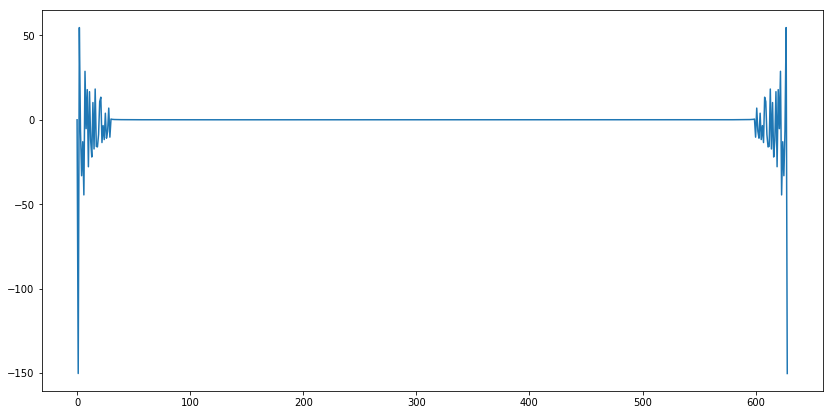

In [206]:
# Take the simple FFT, after removing the mean

Vp = V - V.mean()

#To match the sign above, roll the array so it starts at t=0. 
# Vp = np.roll(Vp, int(-NT/2) ) Too fussy: just know the sign is opposite

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
Vspec = np.fft.fft( Vp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(Vspec.real)
#ax.plot(Vspec.imag)

Text(0,0.5,'Some measure of cosine component amplitude')

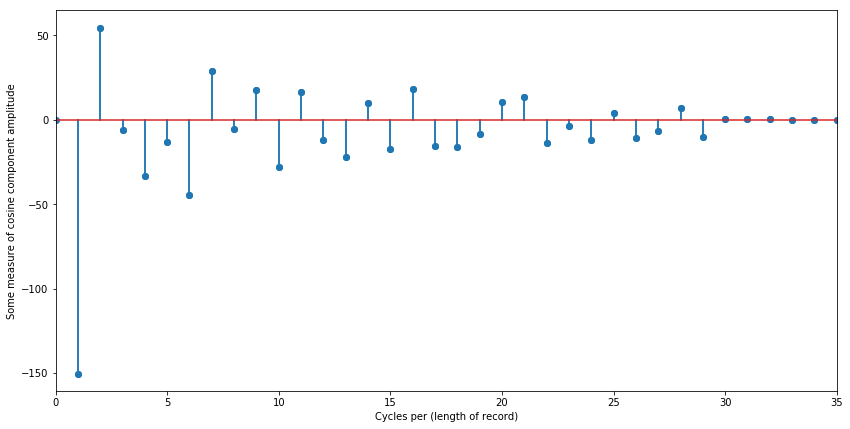

In [207]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Vspec.real)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')

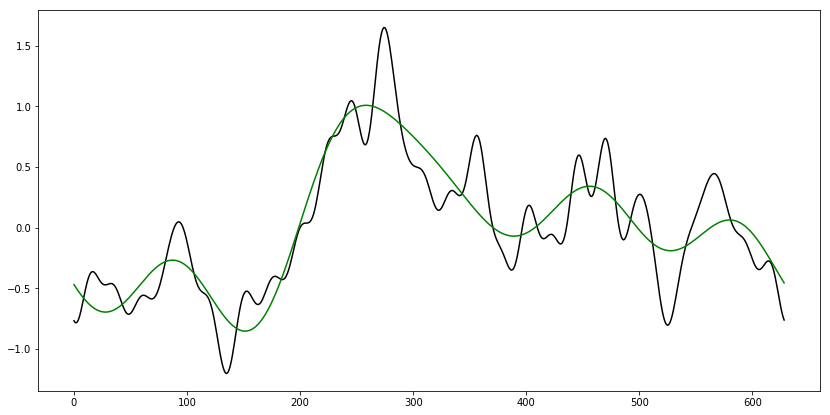

In [208]:
# Mess with the spectrum and reconstruct (a way of filtering)

# Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 5

Vspec_trunc = Vspec.copy()
Vspec_trunc[np.where(freqs > TRUNC)] *= 0. 
Vrecon = np.fft.ifft(Vspec_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(Vp,      color='black')
ax.plot(Vrecon,  color='green')

# Power spectrum is the squared amplitude of the spectrum

Variance is 0.3063784677614639 (m/s)^2: matches 0.30637846776146443


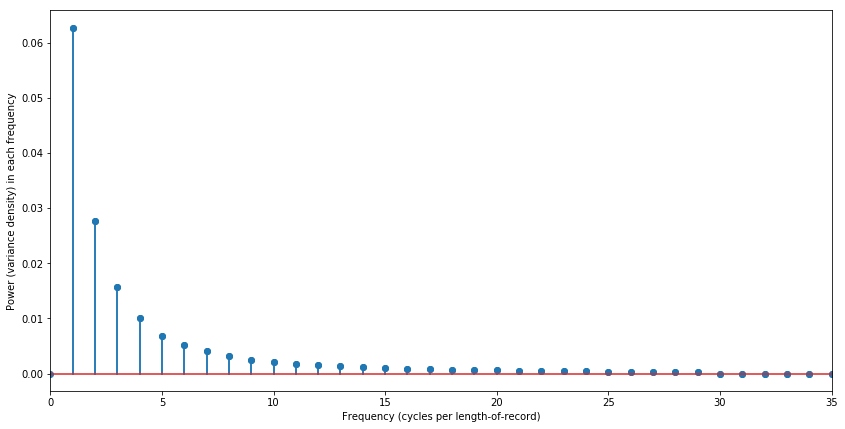

In [209]:
# Complex conjugate does the squaring
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Power)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')

print('Variance is', Vp.var(), '(m/s)^2: matches', sum(Power))

-------------

# Reconstruction with phase=0 

## Phase spectrum is the complex number's phase angle

Text(0,0.5,'Phase angle atan(cosine_part/sine_part) in each frequency')

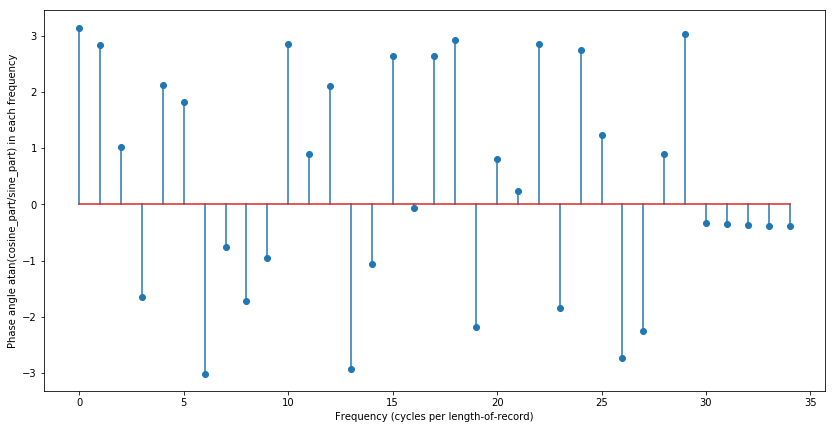

In [211]:
# Phase angle of complex number
Phase = np.angle(Vspec)

fig,ax=plt.subplots(1,1) 
ax.stem(freqs[0:N+5], Phase[0:N+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Phase angle atan(cosine_part/sine_part) in each frequency')

0.3063784677614636 0.3063784677614639


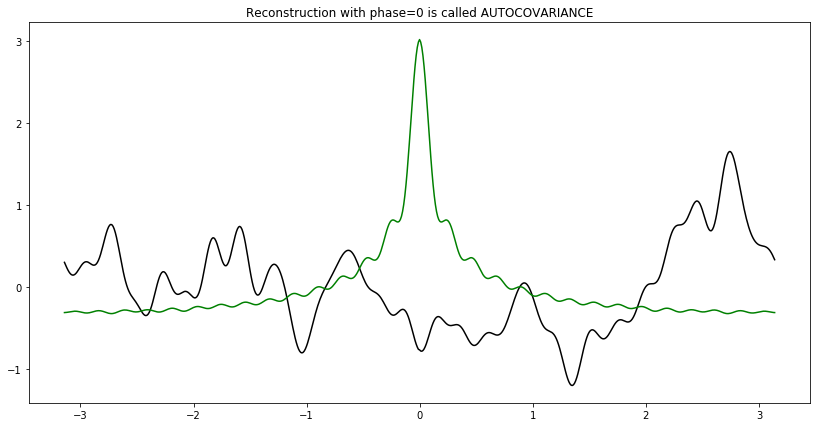

In [227]:
# Reconstruct with phase angle all set to 0 (all components set to pure cosine)
FakePhase = Phase *0 

# Construct a spectrum using that fake phase info
FakeSpec = np.abs(Vspec) * np.exp(1j*FakePhase)
Vrecon = np.fft.ifft(FakeSpec).real

# For clarity, let's roll it into the [-pi,pi] axis
fig,ax=plt.subplots(1,1) 
ax.plot(omega0t, np.roll(Vp,    int(NT/2)), color='black')
ax.plot(omega0t, np.roll(Vrecon,int(NT/2)), color='green')
ax.set_title('Reconstruction with phase=0 is called AUTOCOVARIANCE')

# Has same variance, but all packed at a spike that acts as a sort of "composite excursion"
print(Vrecon.var(), Vp.var())

------------
<a name='autocorrelation'></a>
# Autocorrelation and autocovariance 

In [228]:
lags = np.arange(-200,200)
cxx=0.*lags

for ind,tau in enumerate(lags):
    if tau<0:
        cxx[ind]=np.mean(Vp[:tau]*Vp[-tau:])
    elif tau==0:
        cxx[ind]=np.mean(Vp*Vp)
    else:
        cxx[ind]=np.mean(Vp[:-tau]*Vp[tau:])
        

Text(0,0.5,'$C_{xx} [(m/s)^2]$')

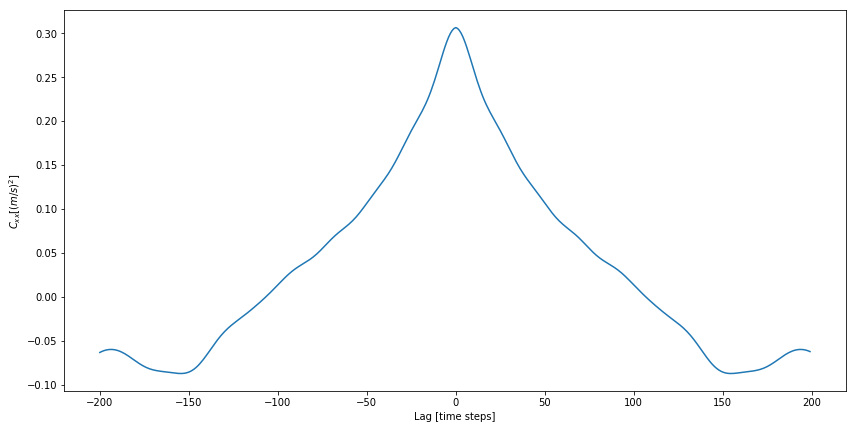

In [229]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx)
ax.set_xlabel('Lag [time steps]')
ax.set_ylabel('$C_{xx} [(m/s)^2]$')

We define the **lag correlation coefficient** as
\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}

This is unitless, and note that $\rho_{xx}(0)=1$.  

(-1, 1)

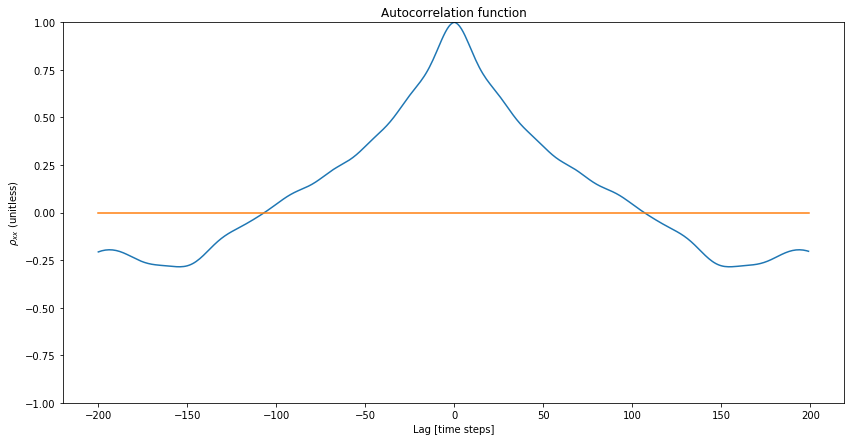

In [230]:
fig,ax=plt.subplots(1,1)

ax.plot(lags,cxx/np.var(Vp))
ax.plot(lags,cxx/np.var(Vp)*0)

ax.set_xlabel('Lag [time steps]')
ax.set_ylabel(r'$\rho_{xx}$ (unitless)')
ax.set_title('Autocorrelation function')

ax.set_ylim([-1,1])

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical "noise"

## Let's look at central Pacific SST again

In [233]:
from netCDF4 import Dataset

# Trick: a loop over keys, building a command. Then, execute that command!
datafile = Dataset('../../notebooks/Eq_timelon_sections.nc',mode='r')
for key in datafile.variables.keys(): 
    print( key +"=datafile['"+key+"'][:].squeeze()") # to show the command
    exec( key +"=datafile['"+key+"'][:].squeeze()")
datafile.close()

lon=datafile['lon'][:].squeeze()
time=datafile['time'][:].squeeze()
olr=datafile['olr'][:].squeeze()
precip=datafile['precip'][:].squeeze()
slp=datafile['slp'][:].squeeze()
sst=datafile['sst'][:].squeeze()
uwnd=datafile['uwnd'][:].squeeze()


Text(0.5,1,'CPAC and EPAC SST (240 mos, from Jan 1980)')

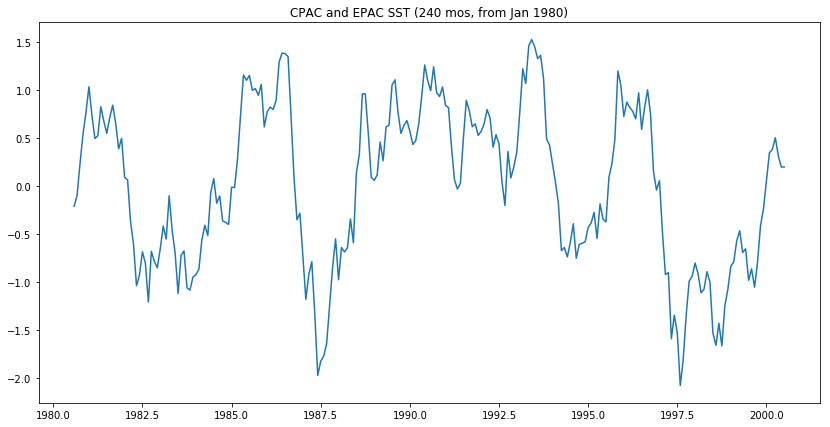

In [311]:
CPAC = sst[:,np.where(lon == 185)].ravel()

# Remove seasonal cycle 
calmos = np.arange(12) ## Runs from 0-11, not 1-12, CAREFUL! 
# I happen to know the data begin with a January. CAREFUL! Not a general approach
months = np.arange(len(CPAC)) 
for imo in calmos:
    yess = np.where(imo == months%12)
    CPAC[yess] -= np.mean(CPAC[ yess ] )

    
yyyy = 1980 + time/12. + 0.5  

fig,ax=plt.subplots(1,1)
ax.plot(yyyy, CPAC)
title('CPAC and EPAC SST (240 mos, from Jan 1980)')

# Postulate an "explanation" of SST by prior SST
$SST_t = intercept + c \cdot SST_{t-1} + residual_t$

Text(0.5,1,'SST and prior month SST')

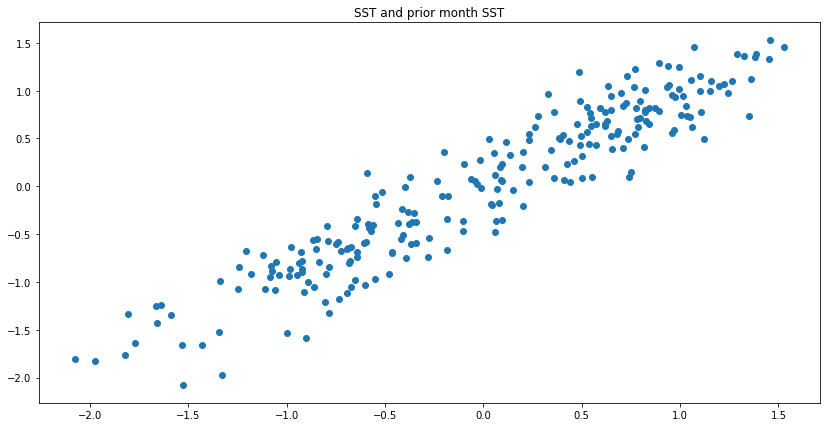

In [312]:
CPAC_1 = np.roll(CPAC,-1) # same data rolled back one month

fig,ax = plt.subplots(1,1)

ax.scatter(CPAC, CPAC_1)
ax.set_title('SST and prior month SST')

In [313]:
# c = np.corrcoef(CPAC, np.roll(CPAC,-1))[0,1] # Since the variances are the same, reg = cor

In [314]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(CPAC,CPAC_1)
    
Prediction = intercept + slope*CPAC_1
print( slope, intercept )
print("r-squared:", r_value**2)

0.9437326284756107 5.813247653044492e-09
r-squared: 0.890631274049485


In [315]:
resid = CPAC - Prediction

Text(0.5,1,'SST and residual of AR1 prediction')

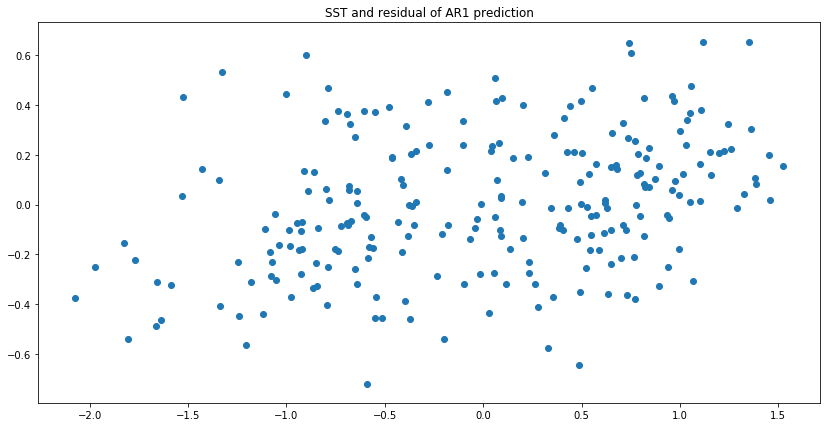

In [316]:
fig,ax = plt.subplots(1,1)

ax.scatter(CPAC, resid)
ax.set_title('SST and residual of AR1 prediction')

## Not a bad fit -- the residual has little relationship
#### Model the residual with random noise 

In [317]:
sigma = np.std(resid)
FAKE_resid = np.random.randn( len(CPAC) )*sigma

# Make some fake data
FAKE = CPAC*0 + np.mean(CPAC) # right shaped container, mean value

for i in 1+np.arange(len(CPAC)-1): 
    FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma


Text(0.5,1,'CPAC and AR1: Which is real and which is FAKE?')

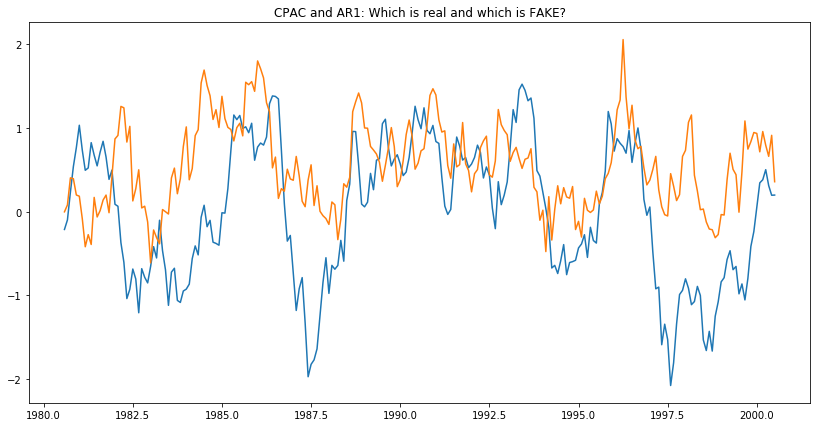

In [318]:
fig,ax=plt.subplots(1,1)
ax.plot(yyyy, CPAC)
ax.plot(yyyy, FAKE)
title('CPAC and AR1: Which is real and which is FAKE?')